# // Importing libraries //

In [1271]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion # These ones are new!
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, Imputer

%matplotlib inline

sns.set_style('darkgrid')

# // Reading in the data //

In [1272]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000


In [1273]:
test = pd.read_csv('test.csv')
test.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


# // Basic EDA //

In [1274]:
# First I want the column names to be uniformly formatted just for consistency.

train.rename(columns= {col: col.lower().replace(' ','_') for col in train.columns}, inplace=True)
test.rename(columns= {col: col.lower().replace(' ','_') for col in test.columns}, inplace=True)

In [1275]:
train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [1276]:
train.shape

(2051, 82)

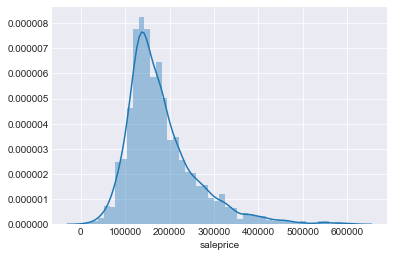

In [1277]:
sns.distplot(train.saleprice);
# Hmm, seems pretty skewed, I'll deal with that later

# // Feature Cleaning and Manipulation //

### _I'll start by dealing with null values first_:

In [1278]:
train.isnull().sum().sort_values(ascending = False)[0:27];

In [1279]:
train.pool_qc.value_counts();

In [1280]:
poolqc_encoder = {
    'Gd': 'Gd',
    'TA': 'TA',
    'Fa': 'Fa',
    'Ex': 'Ex',
    np.nan: 'NA'
}
train['pool_qc'] = train['pool_qc'].map(poolqc_encoder)

In [1281]:
train.misc_feature.value_counts();

In [1282]:
misc_feature_encoder = {
    'Shed': 'Shed',
    'Gar2': 'Gar2',
    'Othr': 'Othr',
    'Elev': 'Elev',
    'TenC': 'TenC',
    'NA': 'NA',
    np.nan: 'NA'
}
train['misc_feature'] = train['misc_feature'].map(misc_feature_encoder)

In [1283]:
train.alley.value_counts();

In [1284]:
alley_encoder = {
    'Grvl': 'Grvl',
    'Pave': 'Pave',
    'NA': 'NA',
    np.nan: 'NA'
}
train['alley'] = train['alley'].map(alley_encoder)

In [1285]:
train.fence.value_counts();

In [1286]:
fence_encoder = {
    'MnPrv': 'MnPrv',
    'GdPrv': 'GdPrv',
    'GdWo': 'GdWo',
    'MnWw': 'MnWw',
    np.nan: 'NA'
}
train['fence'] = train['fence'].map(fence_encoder)

In [1287]:
train.fireplace_qu.value_counts();

In [1288]:
fireplacequ_encoder = {
    'Gd': 'Gd',
    'TA': 'TA',
    'Fa': 'Fa',
    'Ex': 'Ex',
    'Po': 'Po',
    np.nan: 'NA'
}
train['fireplace_qu'] = train['fireplace_qu'].map(fireplacequ_encoder)
train['garage_cond'] = train['garage_cond'].map(fireplacequ_encoder)
train['garage_qual'] = train['garage_qual'].map(fireplacequ_encoder)
train['bsmt_cond'] = train['bsmt_cond'].map(fireplacequ_encoder)
train['bsmt_qual'] = train['bsmt_qual'].map(fireplacequ_encoder)

In [1289]:
train.garage_cond.value_counts();

In [1290]:
train.garage_qual.value_counts();

In [1291]:
# Next up is lot_frontage, let's take a look at other places in the similar neighborhood.

In [1292]:
neigh_frontage_means = train.groupby('neighborhood')['lot_frontage'].mean().to_dict()

In [1293]:
neigh_frontage_means['Blmngtn']

47.25

In [1294]:
train['lot_frontage'].head(20);

In [1295]:
[imputer(cell) for cell in train['neighborhood']];

In [1296]:
def imputer(cell):
    try:
        new_cell = neigh_frontage_means[cell]
        return new_cell
    except:
        pass

In [1297]:
neigh_frontage_means['Blueste']

27.666666666666668

In [1298]:
# Imputing missing lot_frontage values with the average neghborhood one in their area.
train['lot_frontage'] = train.apply(lambda x: neigh_frontage_means[x.neighborhood] if np.isnan(x.lot_frontage) else x.lot_frontage, axis=1)

In [1299]:
# Still have a couple NaN's, let's decide on what to do...
# Mean and median are very close so I'll do the mean.
train.lot_frontage.fillna(train.lot_frontage.mean(), inplace=True)

In [1300]:
train.lot_frontage.value_counts();

In [1301]:
garage_finish_encoder = {
    'Fin': 'Fin',
    'RFn': 'RFn',
    'Unf': 'Unf',
    np.nan: 'NA'
}
train['garage_finish'] = train['garage_finish'].map(garage_finish_encoder)

In [1302]:
train.garage_finish.value_counts();

In [1303]:
# Noticed this weird thing while doing the groupby below:
train.loc[train.garage_yr_blt > 2018, :]['garage_yr_blt']

1699    2207.0
Name: garage_yr_blt, dtype: float64

In [1304]:
# Going to just drop that row:
train.drop(1699, inplace=True)

In [1305]:
# Want to impute with that same method as above
grgyr_yrblt_means = train.groupby('year_built')['garage_yr_blt'].mean().to_dict()

In [1306]:
train['garage_yr_blt'] = train.apply(lambda x: grgyr_yrblt_means[x.year_built] if np.isnan(x.garage_yr_blt) else x.garage_yr_blt, axis=1)

In [1307]:
# So somehow this still resulted in like 6 NaN's... what to do with them?
# Looks like the mean and median are both very close, I'll just impute it with mean.
train.garage_yr_blt.fillna(train.garage_yr_blt.mean(), inplace=True)

In [1308]:
train.garage_type.value_counts();

In [1309]:
garage_type_encoder = {
    'Attchd': 'Attchd',
    'Detchd': 'Detchd',
    'BuiltIn': 'BuiltIn',
    'Basment': 'Basment',
    '2Types': '2Types',
    'CarPort': 'CarPort',
    np.nan: 'NA'
}
train['garage_type'] = train['garage_type'].map(garage_type_encoder)

In [1310]:
train.bsmt_exposure.value_counts();

In [1311]:
bsmt_exp_encoder = {
    'No': 'No',
    'Av': 'Av',
    'Gd': 'Gd',
    'Mn': 'Mn',
    np.nan: 'NA'
}
train['bsmt_exposure'] = train['bsmt_exposure'].map(bsmt_exp_encoder)

In [1312]:
train.bsmtfin_type_2.value_counts();

In [1313]:
bsmt_fin_encoder = {
    'GLQ': 'GLQ',
    'ALQ': 'ALQ',
    'BLQ': 'BLQ',
    'Rec': 'Rec',
    'LwQ': 'LwQ',
    'Unf': 'Unf',
    np.nan: 'NA'
}
train['bsmtfin_type_1'] = train['bsmtfin_type_1'].map(bsmt_fin_encoder)
train['bsmtfin_type_2'] = train['bsmtfin_type_2'].map(bsmt_fin_encoder)

In [1314]:
train.mas_vnr_type.value_counts();

In [1315]:
mas_vnr_encoder = {
    'BrkCmn': 'BrkCmn',
    'BrkFace': 'BrkFace',
    'Stone': 'Stone',
    'CBlock': 'CBlock',
    'None': 'NA',
    np.nan: 'NA'
}
train['mas_vnr_type'] = train['mas_vnr_type'].map(mas_vnr_encoder)

In [1316]:
# Yes, it may not make much of a difference but I'm going to impute, damn it!
vnr_dict = train.groupby('mas_vnr_type')['mas_vnr_area'].mean().to_dict()

In [1317]:
train['mas_vnr_area'] = train.apply(lambda x: vnr_dict[x.mas_vnr_type] if np.isnan(x.mas_vnr_area) else x.mas_vnr_area, axis=1)

In [1318]:
train.bsmt_full_bath.fillna(train.bsmt_full_bath.median(), inplace=True)

train.bsmt_half_bath.fillna(train.bsmt_half_bath.median(), inplace=True)

train.total_bsmt_sf.fillna(train.total_bsmt_sf.median(), inplace=True)

train.bsmtfin_sf_2.fillna(train.bsmtfin_sf_2.median(), inplace=True)
train.bsmt_unf_sf.fillna(train.bsmt_unf_sf.median(), inplace=True)
train.bsmtfin_sf_1.fillna(train.bsmtfin_sf_1.median(), inplace=True)
train.garage_cars.fillna(train.garage_cars.median(), inplace=True)
train.garage_area.fillna(train.garage_area.median(), inplace=True)

In [1319]:
train.isnull().sum().sort_values(ascending = False);
# No more nulls! Only had to go totally insane to get there!

### _Making ordinal categories:_

In [1320]:
simple_qual_encoded = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0,
    np.nan: 0
}

train['exter_qual'] = train['exter_qual'].map(simple_qual_encoded)
train['exter_cond'] = train['exter_cond'].map(simple_qual_encoded)
train['bsmt_qual'] = train['bsmt_qual'].map(simple_qual_encoded)
train['bsmt_cond'] = train['bsmt_cond'].map(simple_qual_encoded)
train['heating_qc'] = train['heating_qc'].map(simple_qual_encoded)
train['kitchen_qual'] = train['kitchen_qual'].map(simple_qual_encoded)
train['fireplace_qu'] = train['fireplace_qu'].map(simple_qual_encoded)
train['garage_qual'] = train['garage_qual'].map(simple_qual_encoded)
train['garage_cond'] = train['garage_cond'].map(simple_qual_encoded)
train['pool_qc'] = train['pool_qc'].map(simple_qual_encoded)

In [1321]:
centralair_encoded = {
    'Y': 1,
    'N': 0
}
train['central_air'] = train['central_air'].map(centralair_encoded)

In [1322]:
functional_encoded = {
    'Typ':7,
    'Min1':6,
    'Min2':5,
    'Mod':4,
    'Maj1':3,
    'Maj2':2,
    'Sev':1,
    'Sal': 0
}
train['functional'] = train['functional'].map(functional_encoded)

In [1323]:
train.garage_finish.value_counts();

In [1324]:
garage_finish_encoded = {
    'Fin': 3,
    'Rfn': 2,
    'Unf': 1,
    'NA': 0
}
train['garage_finish'] = train['garage_finish'].map(garage_finish_encoded)

In [1325]:
# Those are really the only ones where I can say I feel slam dunk sure in assigning them an
# ordinal ranking. All of the other ones could *potentially* have some form of ambiguity.

### _Making nominal categories aka one-hot-encoding aka dummies:_

In [1326]:
train['ms_subclass'] = train['ms_subclass'].astype('category')
train = pd.get_dummies(train, columns = ['ms_subclass'], drop_first = True)

train['ms_zoning'] = train['ms_zoning'].astype('category')
train = pd.get_dummies(train, columns = ['ms_zoning'], drop_first = True)

train['street'] = train['street'].astype('category')
train = pd.get_dummies(train, columns = ['street'], drop_first = True)

train['alley'] = train['alley'].astype('category')
train = pd.get_dummies(train, columns = ['alley'], drop_first = True)

train['lot_shape'] = train['lot_shape'].astype('category')
train = pd.get_dummies(train, columns = ['lot_shape'], drop_first = True)

train['land_contour'] = train['land_contour'].astype('category')
train = pd.get_dummies(train, columns = ['land_contour'], drop_first = True)

train['utilities'] = train['utilities'].astype('category')
train = pd.get_dummies(train, columns = ['utilities'], drop_first = True)

train['lot_config'] = train['lot_config'].astype('category')
train = pd.get_dummies(train, columns = ['lot_config'], drop_first = True)

train['land_slope'] = train['land_slope'].astype('category')
train = pd.get_dummies(train, columns = ['land_slope'], drop_first = True)

train['neighborhood'] = train['neighborhood'].astype('category')
train = pd.get_dummies(train, columns = ['neighborhood'], drop_first = True)

train['condition_1'] = train['condition_1'].astype('category')
train = pd.get_dummies(train, columns = ['condition_1'], drop_first = True)

train['condition_2'] = train['condition_2'].astype('category')
train = pd.get_dummies(train, columns = ['condition_2'], drop_first = True)

train['bldg_type'] = train['bldg_type'].astype('category')
train = pd.get_dummies(train, columns = ['bldg_type'], drop_first = True)

train['house_style'] = train['house_style'].astype('category')
train = pd.get_dummies(train, columns = ['house_style'], drop_first = True)

train['roof_style'] = train['roof_style'].astype('category')
train = pd.get_dummies(train, columns = ['roof_style'], drop_first = True)

train['roof_matl'] = train['roof_matl'].astype('category')
train = pd.get_dummies(train, columns = ['roof_matl'], drop_first = True)

train['exterior_1st'] = train['exterior_1st'].astype('category')
train = pd.get_dummies(train, columns = ['exterior_1st'], drop_first = True)

train['exterior_2nd'] = train['exterior_2nd'].astype('category')
train = pd.get_dummies(train, columns = ['exterior_2nd'], drop_first = True)

train['mas_vnr_type'] = train['mas_vnr_type'].astype('category')
train = pd.get_dummies(train, columns = ['mas_vnr_type'], drop_first = True)

train['foundation'] = train['foundation'].astype('category')
train = pd.get_dummies(train, columns = ['foundation'], drop_first = True)

train['bsmt_exposure'] = train['bsmt_exposure'].astype('category')
train = pd.get_dummies(train, columns = ['bsmt_exposure'], drop_first = True)

train['bsmtfin_type_1'] = train['bsmtfin_type_1'].astype('category')
train = pd.get_dummies(train, columns = ['bsmtfin_type_1'], drop_first = True)

train['bsmtfin_type_2'] = train['bsmtfin_type_2'].astype('category')
train = pd.get_dummies(train, columns = ['bsmtfin_type_2'], drop_first = True)

train['heating'] = train['heating'].astype('category')
train = pd.get_dummies(train, columns = ['heating'], drop_first = True)

train['electrical'] = train['electrical'].astype('category')
train = pd.get_dummies(train, columns = ['electrical'], drop_first = True)

train['garage_type'] = train['garage_type'].astype('category')
train = pd.get_dummies(train, columns = ['garage_type'], drop_first = True)

train['paved_drive'] = train['paved_drive'].astype('category')
train = pd.get_dummies(train, columns = ['paved_drive'], drop_first = True)

train['fence'] = train['fence'].astype('category')
train = pd.get_dummies(train, columns = ['fence'], drop_first = True)

train['misc_feature'] = train['misc_feature'].astype('category')
train = pd.get_dummies(train, columns = ['misc_feature'], drop_first = True)

### _Outlier hunting_:

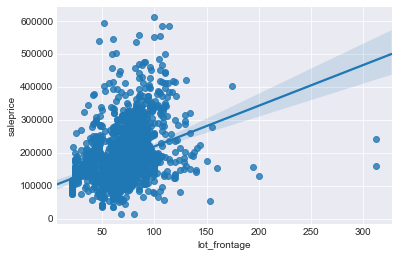

In [1327]:
sns.regplot(train.lot_frontage , train.saleprice, train);

In [1328]:
train.loc[train.lot_frontage > 300, :]

,id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,paved_drive_Y,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA,misc_feature_Gar2,misc_feature_NA,misc_feature_Othr,misc_feature_Shed,misc_feature_TenC
960,1499,908154235,313.0,63887,10,5,2008,2008,796.0,5,...,1,0,0,0,1,0,1,0,0,0
1335,1266,535427070,313.0,27650,7,7,1960,2007,0.0,3,...,1,0,0,0,1,0,1,0,0,0


In [1329]:
train.drop([960, 1335], inplace=True)

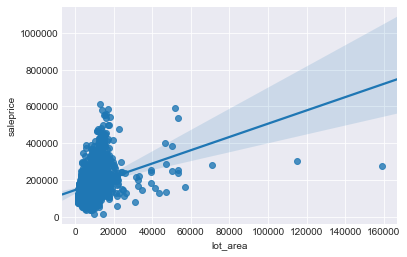

In [1330]:
sns.regplot(train.lot_area , train.saleprice, train);

In [1331]:
train.loc[train.lot_area > 100000, :]

,id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,paved_drive_Y,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA,misc_feature_Gar2,misc_feature_NA,misc_feature_Othr,misc_feature_Shed,misc_feature_TenC
471,2116,906426060,92.5,159000,6,7,1958,2006,472.0,4,...,1,0,0,0,1,0,0,0,1,0
694,2072,905301050,92.5,115149,7,5,1971,2002,351.0,3,...,1,0,0,0,1,0,1,0,0,0


In [1332]:
train.drop([471, 694], inplace=True)

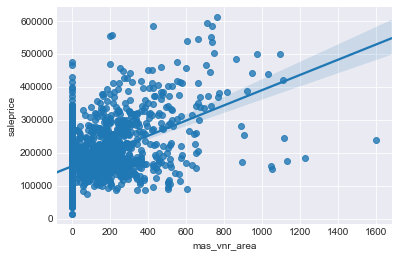

In [1333]:
sns.regplot(train.mas_vnr_area, train.saleprice, train);
# I think I'll leave it

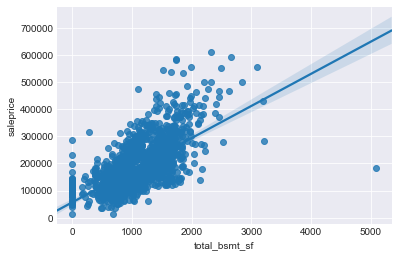

In [1334]:
sns.regplot(train.total_bsmt_sf, train.saleprice, train);

In [1335]:
train.loc[train.total_bsmt_sf > 5000, :]

,id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,paved_drive_Y,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA,misc_feature_Gar2,misc_feature_NA,misc_feature_Othr,misc_feature_Shed,misc_feature_TenC
1885,2181,908154195,128.0,39290,10,5,2008,2009,1224.0,5,...,1,0,0,0,1,0,0,0,0,0


In [1336]:
train.drop(1885, inplace=True)

### _Dealing with skewness:_

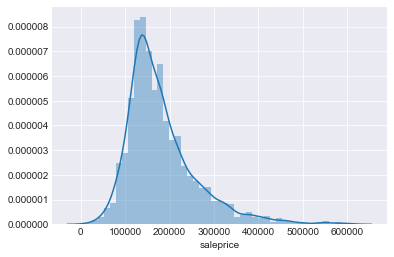

In [1337]:
sns.distplot(train.saleprice);
# Hmm, seems pretty skewed, guess I'd better try to change that.

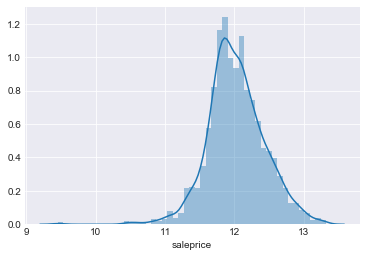

In [1338]:
sns.distplot(train['saleprice'].apply(lambda x: np.log(x)));

In [1339]:
# train['saleprice'] = train['saleprice'].apply(lambda x: np.log(x))

### _Finding features that don't really matter either way:_

In [1340]:
# Go back and visit this to improve score if possible

### _New feature engineering_:

In [1341]:
train['total_porch_area'] = train['wood_deck_sf'] + train['open_porch_sf'] + train['enclosed_porch'] + train['3ssn_porch'] + train['screen_porch']

# train.drop(['wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'], axis=1, inplace=True)

# Seem to be quite a few dealing with area / square footage:

train['master_sq_ft'] = train['lot_area'] + train['total_bsmt_sf'] + train['low_qual_fin_sf'] + \
train['gr_liv_area'] + train['garage_area'] + train['total_porch_area'] +\
train['pool_area'] + train['mas_vnr_area'] + train['bsmtfin_sf_1'] + train['bsmtfin_sf_2'] +\
train['bsmt_unf_sf'] + train['1st_flr_sf'] + train['2nd_flr_sf']

# train.drop(['lot_area','total_bsmt_sf','low_qual_fin_sf', 'gr_liv_area', 'garage_area',\
#             'total_porch_area', 'pool_area', 'mas_vnr_area', 'bsmtfin_sf_1', \
#             'bsmtfin_sf_2', 'bsmt_unf_sf', '1st_flr_sf', '2nd_flr_sf'], axis=1, inplace=True)

train['master_overall'] = train['overall_cond'] + train['overall_qual']

# train.drop(['overall_cond', 'overall_qual'], axis=1, inplace=True)

train['master_garage'] = train['garage_qual'] + train['garage_cond']

# train.drop(['garage_qual', 'garage_cond'], axis=1, inplace=True)

In [1342]:
train.loc[train['year_built'] == train['yr_sold'], :];
# Want to be making a "New House" variable somehow...

train['new_house'] = (train['year_built'] == train['yr_sold']).as_matrix()

new_house_encoded = {
    False: 0,
    True: 1
}
train['new_house'] = train['new_house'].map(new_house_encoded)

train['new_house'].value_counts() # Yay!

In [1345]:
# Want to do the same thing but for a remodeled category:
train.loc[train['year_built'] != train['year_remod/add'], :];

train['remodeled'] = (train['year_built'] != train['year_remod/add']).as_matrix()

train['remodeled'] = train['remodeled'].map(new_house_encoded)

# // Manipulating test set in the same way //

### _Nulls:_

In [1346]:
test['pool_qc'] = test['pool_qc'].map(poolqc_encoder)
test['misc_feature'] = test['misc_feature'].map(misc_feature_encoder)
test['alley'] = test['alley'].map(alley_encoder)
test['fence'] = test['fence'].map(fence_encoder)
test['fireplace_qu'] = test['fireplace_qu'].map(fireplacequ_encoder)
test['garage_cond'] = test['garage_cond'].map(fireplacequ_encoder)
test['garage_qual'] = test['garage_qual'].map(fireplacequ_encoder)
test['bsmt_cond'] = test['bsmt_cond'].map(fireplacequ_encoder)
test['bsmt_qual'] = test['bsmt_qual'].map(fireplacequ_encoder)
test['garage_finish'] = test['garage_finish'].map(garage_finish_encoder)
test['garage_type'] = test['garage_type'].map(garage_type_encoder)
test['bsmt_exposure'] = test['bsmt_exposure'].map(bsmt_exp_encoder)
test['bsmtfin_type_1'] = test['bsmtfin_type_1'].map(bsmt_fin_encoder)
test['bsmtfin_type_2'] = test['bsmtfin_type_2'].map(bsmt_fin_encoder)
test['mas_vnr_type'] = test['mas_vnr_type'].map(mas_vnr_encoder)

test['lot_frontage'] = test.apply(lambda x: neigh_frontage_means[x.neighborhood] if np.isnan(x.lot_frontage) else x.lot_frontage, axis=1)
test.lot_frontage.fillna(test.lot_frontage.mean(), inplace=True)

test['mas_vnr_area'] = test.apply(lambda x: vnr_dict[x.mas_vnr_type] if np.isnan(x.mas_vnr_area) else x.mas_vnr_area, axis=1)

test.bsmt_full_bath.fillna(test.bsmt_full_bath.median(), inplace=True)
test.bsmt_half_bath.fillna(test.bsmt_half_bath.median(), inplace=True)
test.total_bsmt_sf.fillna(test.total_bsmt_sf.median(), inplace=True)
test.bsmtfin_sf_2.fillna(test.bsmtfin_sf_2.median(), inplace=True)
test.bsmt_unf_sf.fillna(test.bsmt_unf_sf.median(), inplace=True)
test.bsmtfin_sf_1.fillna(test.bsmtfin_sf_1.median(), inplace=True)
test.garage_cars.fillna(test.garage_cars.median(), inplace=True)
test.garage_area.fillna(test.garage_area.median(), inplace=True)

### _Ordinals:_

In [1347]:
test['exter_qual'] = test['exter_qual'].map(simple_qual_encoded)
test['exter_cond'] = test['exter_cond'].map(simple_qual_encoded)
test['bsmt_qual'] = test['bsmt_qual'].map(simple_qual_encoded)
test['bsmt_cond'] = test['bsmt_cond'].map(simple_qual_encoded)
test['heating_qc'] = test['heating_qc'].map(simple_qual_encoded)
test['kitchen_qual'] = test['kitchen_qual'].map(simple_qual_encoded)
test['fireplace_qu'] = test['fireplace_qu'].map(simple_qual_encoded)
test['garage_qual'] = test['garage_qual'].map(simple_qual_encoded)
test['garage_cond'] = test['garage_cond'].map(simple_qual_encoded)
test['pool_qc'] = test['pool_qc'].map(simple_qual_encoded)
test['central_air'] = test['central_air'].map(centralair_encoded)
test['functional'] = test['functional'].map(functional_encoded)
test['garage_finish'] = test['garage_finish'].map(garage_finish_encoded)

### _Nominals:_

In [1348]:
test['ms_subclass'] = test['ms_subclass'].astype('category')
test = pd.get_dummies(test, columns = ['ms_subclass'], drop_first = True)
test['ms_zoning'] = test['ms_zoning'].astype('category')
test = pd.get_dummies(test, columns = ['ms_zoning'], drop_first = True)
test['street'] = test['street'].astype('category')
test = pd.get_dummies(test, columns = ['street'], drop_first = True)
test['alley'] = test['alley'].astype('category')
test = pd.get_dummies(test, columns = ['alley'], drop_first = True)
test['lot_shape'] = test['lot_shape'].astype('category')
test = pd.get_dummies(test, columns = ['lot_shape'], drop_first = True)
test['land_contour'] = test['land_contour'].astype('category')
test = pd.get_dummies(test, columns = ['land_contour'], drop_first = True)
test['utilities'] = test['utilities'].astype('category')
test = pd.get_dummies(test, columns = ['utilities'], drop_first = True)
test['lot_config'] = test['lot_config'].astype('category')
test = pd.get_dummies(test, columns = ['lot_config'], drop_first = True)
test['land_slope'] = test['land_slope'].astype('category')
test = pd.get_dummies(test, columns = ['land_slope'], drop_first = True)
test['neighborhood'] = test['neighborhood'].astype('category')
test = pd.get_dummies(test, columns = ['neighborhood'], drop_first = True)
test['condition_1'] = test['condition_1'].astype('category')
test = pd.get_dummies(test, columns = ['condition_1'], drop_first = True)
test['condition_2'] = test['condition_2'].astype('category')
test = pd.get_dummies(test, columns = ['condition_2'], drop_first = True)
test['bldg_type'] = test['bldg_type'].astype('category')
test = pd.get_dummies(test, columns = ['bldg_type'], drop_first = True)
test['house_style'] = test['house_style'].astype('category')
test = pd.get_dummies(test, columns = ['house_style'], drop_first = True)
test['roof_style'] = test['roof_style'].astype('category')
test = pd.get_dummies(test, columns = ['roof_style'], drop_first = True)
test['roof_matl'] = test['roof_matl'].astype('category')
test = pd.get_dummies(test, columns = ['roof_matl'], drop_first = True)
test['exterior_1st'] = test['exterior_1st'].astype('category')
test = pd.get_dummies(test, columns = ['exterior_1st'], drop_first = True)
test['exterior_2nd'] = test['exterior_2nd'].astype('category')
test = pd.get_dummies(test, columns = ['exterior_2nd'], drop_first = True)
test['mas_vnr_type'] = test['mas_vnr_type'].astype('category')
test = pd.get_dummies(test, columns = ['mas_vnr_type'], drop_first = True)
test['foundation'] = test['foundation'].astype('category')
test = pd.get_dummies(test, columns = ['foundation'], drop_first = True)
test['bsmt_exposure'] = test['bsmt_exposure'].astype('category')
test = pd.get_dummies(test, columns = ['bsmt_exposure'], drop_first = True)
test['bsmtfin_type_1'] = test['bsmtfin_type_1'].astype('category')
test = pd.get_dummies(test, columns = ['bsmtfin_type_1'], drop_first = True)
test['bsmtfin_type_2'] = test['bsmtfin_type_2'].astype('category')
test = pd.get_dummies(test, columns = ['bsmtfin_type_2'], drop_first = True)
test['heating'] = test['heating'].astype('category')
test = pd.get_dummies(test, columns = ['heating'], drop_first = True)
test['electrical'] = test['electrical'].astype('category')
test = pd.get_dummies(test, columns = ['electrical'], drop_first = True)
test['garage_type'] = test['garage_type'].astype('category')
test = pd.get_dummies(test, columns = ['garage_type'], drop_first = True)
test['paved_drive'] = test['paved_drive'].astype('category')
test = pd.get_dummies(test, columns = ['paved_drive'], drop_first = True)
test['fence'] = test['fence'].astype('category')
test = pd.get_dummies(test, columns = ['fence'], drop_first = True)
test['misc_feature'] = test['misc_feature'].astype('category')
test = pd.get_dummies(test, columns = ['misc_feature'], drop_first = True)

### _New features:_

In [1349]:
test['total_porch_area'] = test['wood_deck_sf'] + test['open_porch_sf'] + test['enclosed_porch'] + test['3ssn_porch'] + test['screen_porch']
# test.drop(['wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'], axis=1, inplace=True)

test['master_sq_ft'] = test['lot_area'] + test['total_bsmt_sf'] + test['low_qual_fin_sf'] + \
test['gr_liv_area'] + test['garage_area'] + test['total_porch_area'] +\
test['pool_area'] + test['mas_vnr_area'] + test['bsmtfin_sf_1'] + test['bsmtfin_sf_2'] +\
test['bsmt_unf_sf'] + test['1st_flr_sf'] + test['2nd_flr_sf']
# test.drop(['lot_area','total_bsmt_sf','low_qual_fin_sf', 'gr_liv_area', 'garage_area',\
#             'total_porch_area', 'pool_area', 'mas_vnr_area', 'bsmtfin_sf_1', \
#             'bsmtfin_sf_2', 'bsmt_unf_sf', '1st_flr_sf', '2nd_flr_sf'], axis=1, inplace=True)

test['master_overall'] = test['overall_cond'] + test['overall_qual']
# test.drop(['overall_cond', 'overall_qual'], axis=1, inplace=True)

test['master_garage'] = test['garage_qual'] + test['garage_cond']
# test.drop(['garage_qual', 'garage_cond'], axis=1, inplace=True)

test['new_house'] = (test['year_built'] == test['yr_sold']).as_matrix()
test['new_house'] = test['new_house'].map(new_house_encoded)

test['remodeled'] = (test['year_built'] != test['year_remod/add']).as_matrix()
test['remodeled'] = test['remodeled'].map(new_house_encoded)

# // Trying a model //

In [1350]:
train.corr()['saleprice'].abs().sort_values(ascending=False);

In [1353]:
new_features = ['new_house', 'remodeled', 'master_sq_ft', 'master_overall', 'master_garage']

In [1355]:
zoning_features = [col for col in train.columns if 'zoning_' in col]

In [1392]:
qual_features = [col for col in train.columns if 'qual' in col]

['overall_qual',
 'exter_qual',
 'bsmt_qual',
 'low_qual_fin_sf',
 'kitchen_qual',
 'garage_qual']

In [1357]:
neighborhood_features = [col for col in train.columns if 'neighborhood_' in col]

In [1358]:
final_features = new_features + zoning_features + qual_features + neighborhood_features

In [1162]:
# foundation_features = [col for col in train.columns if 'foundation_' in col]

In [1189]:
features1 = new_features + neighborhood_features

In [1393]:
y = train['saleprice']

In [1174]:
pd.set_option('display.max_rows', 290)

In [1175]:
train._get_numeric_data().isnull().sum();

In [1176]:
features = [col for col in train.columns if col not in ['mo_sold', 'saleprice', 'garage_finish', 'sale_condition', 'sale_type']]

In [1394]:
X = train[final_features]

In [1395]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

In [1396]:
ss = StandardScaler()
ss.fit(X_train)
Xts = ss.transform(X_train)
Xts

array([[-0.2035687 , -0.92152912, -0.4282046 , ..., -0.13639887,
        -0.15943042, -0.09248044],
       [-0.2035687 , -0.92152912,  0.79434899, ..., -0.13639887,
        -0.15943042, -0.09248044],
       [-0.2035687 ,  1.0851529 , -0.12132503, ..., -0.13639887,
        -0.15943042, -0.09248044],
       ..., 
       [-0.2035687 , -0.92152912,  0.02327141, ..., -0.13639887,
        -0.15943042, -0.09248044],
       [-0.2035687 , -0.92152912, -1.58947536, ..., -0.13639887,
        -0.15943042, -0.09248044],
       [ 4.91234644, -0.92152912,  0.35637072, ..., -0.13639887,
        -0.15943042, -0.09248044]])

In [1397]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
lr = LinearRegression()

In [1398]:
lr.fit(Xts, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1399]:
lr.score(Xts, y_train)

0.83273340929591444

In [1400]:
Xhs = ss.transform(X_holdout)

In [1402]:
lr.score(Xhs, y_holdout)

0.82404906057321381

In [1403]:
X_test = test[final_features]

In [1405]:
predictions = lr.predict(X_test)

test['SalePrice'] = predictions

test = test.rename(columns={'id': 'Id'})

In [1406]:
test.head(3)

,Id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,roof_matl_CompShg,exterior_2nd_Stone,heating_OthW,heating_Wall,misc_feature_Gar2,misc_feature_TenC,SalePrice
0,2658,902301120,69.000000,9142,6,8,1910,1950,0.0,3,...,0,0,0,0,0,0,0,0,0,3.800952e+08
1,2718,905108090,72.774648,9662,5,4,1977,1977,0.0,3,...,0,0,0,0,0,0,0,0,0,4.438643e+08
2,2414,528218130,58.000000,17104,7,5,2006,2006,0.0,4,...,0,0,0,0,0,0,0,0,0,5.330785e+08


In [1412]:
test['SalePrice'] = test['SalePrice']/1000

In [1413]:
test.head(3)

,Id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,roof_matl_CompShg,exterior_2nd_Stone,heating_OthW,heating_Wall,misc_feature_Gar2,misc_feature_TenC,SalePrice
0,2658,902301120,69.000000,9142,6,8,1910,1950,0.0,3,...,0,0,0,0,0,0,0,0,0,380095.183166
1,2718,905108090,72.774648,9662,5,4,1977,1977,0.0,3,...,0,0,0,0,0,0,0,0,0,443864.289327
2,2414,528218130,58.000000,17104,7,5,2006,2006,0.0,4,...,0,0,0,0,0,0,0,0,0,533078.492617


In [1414]:
test[['Id', 'SalePrice']].to_csv('p2_reg_27.csv', index=False)

In [1386]:
imp = Imputer()
ss = StandardScaler()

lasso = Lasso(max_iter=2500)
ridge = Ridge(max_iter=2000)
enet = ElasticNet()

pipe = Pipeline([                               # Things need to be in order like a factory
#     ('features', features),
    ('imp', imp),
#     ('poly', poly),
    ('ss', ss),
    ('lasso', lasso),
#     ('ridge', ridge),
#     ('enet', enet),
])

In [1387]:
params = {
    'imp__strategy': ['mean', 'median','most_frequent'],
    'lasso__alpha': np.arange(.001, .15, .0025),
#     'ridge__alpha': np.logspace(0, 5, 200),
#     'enet__alpha' : np.arange(.01, 1.0, .005),
#     'enet__l1_ratio': [.1, .5, .7,.9, .95, .99, 1]
}
rs = RandomizedSearchCV(pipe, param_distributions=params, n_iter=10)
rs.fit(X_train, y_train)
print (rs.best_score_)
print (rs.best_params_)

0.81699475551
{'lasso__alpha': 0.13600000000000001, 'imp__strategy': 'most_frequent'}


In [1388]:
rs.score(X_holdout, y_holdout)

0.82405223919786275

In [1389]:
X_test = test[final_features]

In [1196]:
test.shape

(879, 221)

In [1369]:
test['neighborhood_GrnHill'] = [0 for x in range(1, 880)]
test['neighborhood_Landmrk'] = [0 for x in range(1, 880)]
test['ms_zoning_C (all)'] = [0 for x in range(1, 880)]
test['roof_matl_Membran'] = [0 for x in range(1, 880)]
test['exterior_1st_CBlock'] = [0 for x in range(1, 880)]
test['exterior_1st_ImStucc'] = [0 for x in range(1, 880)]
test['exterior_1st_Stone'] = [0 for x in range(1, 880)]
test['electrical_Mix'] = [0 for x in range(1, 880)]
test['ms_subclass_150'] = [0 for x in range(1, 880)]
test['utilities_NoSeWa'] = [0 for x in range(1, 880)]
test['condition_2_Feedr'] = [0 for x in range(1, 880)]
test['condition_2_RRAe'] = [0 for x in range(1, 880)]
test['condition_2_RRAn'] = [0 for x in range(1, 880)]
test['condition_2_RRNn'] = [0 for x in range(1, 880)]
test['exterior_1st_Stone'] = [0 for x in range(1, 880)]
test['roof_matl_CompShg'] = [0 for x in range(1, 880)]
test['exterior_2nd_Stone'] = [0 for x in range(1, 880)]
test['heating_OthW'] = [0 for x in range(1, 880)]
test['heating_Wall'] = [0 for x in range(1, 880)]
test['misc_feature_Gar2'] = [0 for x in range(1, 880)]
test['misc_feature_TenC'] = [0 for x in range(1, 880)]

In [1390]:
predictions = rs.best_estimator_.predict(X_test)

test['SalePrice'] = predictions

test = test.rename(columns={'id': 'Id'})

test.head(3)

,Id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,roof_matl_CompShg,exterior_2nd_Stone,heating_OthW,heating_Wall,misc_feature_Gar2,misc_feature_TenC,SalePrice
0,2658,902301120,69.000000,9142,6,8,1910,1950,0.0,3,...,0,0,0,0,0,0,0,0,0,125671.155755
1,2718,905108090,72.774648,9662,5,4,1977,1977,0.0,3,...,0,0,0,0,0,0,0,0,0,147312.226436
2,2414,528218130,58.000000,17104,7,5,2006,2006,0.0,4,...,0,0,0,0,0,0,0,0,0,253199.962307


In [1391]:
test[['Id', 'SalePrice']].to_csv('p2_reg_25.csv', index=False)